<a href="https://colab.research.google.com/github/KeysiYTS/toxic-comment-classifier-ml/blob/dev/v2_toxic_comment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### About + References



From: [Kaggle Dataset](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data)  

File descriptions  
- `train.csv` - the training set, contains comments with their binary labels  
- `test.csv` - the test set, you must predict the toxicity probabilities for these comments. To deter hand labeling, the test set contains some comments which are not included in scoring.  
- `test_labels.csv` - labels for the test data; value of -1 indicates it was not used for scoring; 

**References:**    
 - [Text Classification with Machine Learning & NLP](https://monkeylearn.com/text-classification/);  
 - [The Beginner’s Guide to Text Vectorization](https://monkeylearn.com/blog/beginners-guide-text-vectorization/);  
 - [Stop Words](https://en.wikipedia.org/wiki/Stop_word);  
 - [Stop Words in NLP](https://medium.com/@saitejaponugoti/stop-words-in-nlp-5b248dadad47#_=_)
 - [Go-to Guide for Text Classification with Machine Learning](https://monkeylearn.com/blog/text-classification-machine-learning/);  
 - [What is TF-IDF?](https://monkeylearn.com/blog/what-is-tf-idf/)
 - [scikit doc - Multiclass vs Multilabel](https://scikit-learn.org/stable/modules/multiclass.html)


### Importing the data

In [ ]:
!pip install scikit-multilearn --quiet

In [ ]:
import pandas as pd
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

from sklearn.metrics import accuracy_score, hamming_loss, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB

In [ ]:
# Multilabel model
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

In [ ]:
dataset_path = '/content/drive/MyDrive/0. Machine Learning/Projetos/Toxic Comment/train.csv'

In [ ]:
dataset = pd.read_csv(dataset_path)

### Exploring the `Train` Dataset

In [ ]:
dataset.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Checking the output variations

In [ ]:
for col in dataset.columns[2:]:
  print(dataset[col].unique())

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


In [ ]:
dataset.info() , dataset.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


(None, (159571, 8))

In [ ]:
output_distribution = dataset[dataset.columns[2:]].sum()
output_distribution

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

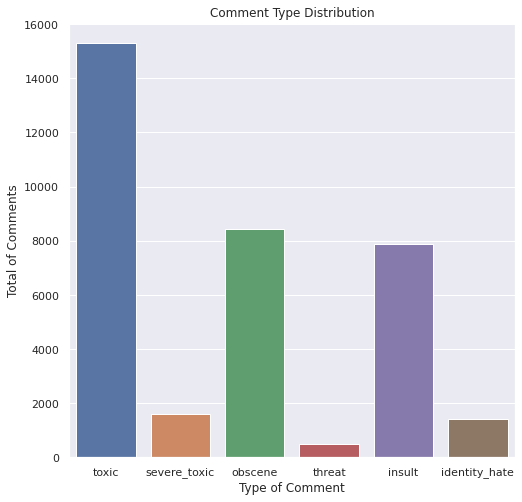

In [ ]:
sns.set()
plt.figure(figsize=(8,8))
sns.barplot(x = dataset.columns[2:], y = output_distribution)
plt.title('Comment Type Distribution')
plt.xlabel('Type of Comment')
plt.ylabel('Total of Comments')
plt.show()

In [ ]:
# adding the columns. If the sum is > 1, the comment is multi labeled
overlapping = dataset[dataset.columns[2:]].sum(axis=1)
overlapping.value_counts()

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64

In [ ]:
sums = dataset[dataset.columns[2:]].sum(axis=1).value_counts()
# Starting from 1 beacause 0 is the comments that are not in any labeled
sums[1:].index, sums[1:].values

(Int64Index([1, 3, 2, 4, 5, 6], dtype='int64'),
 array([6360, 4209, 3480, 1760,  385,   31]))

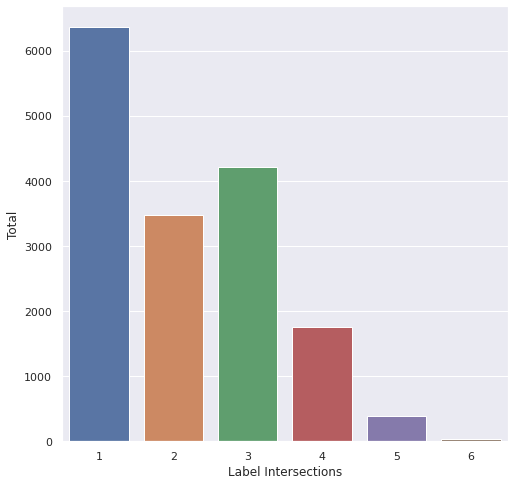

In [ ]:
plt.figure(figsize=(8,8))
sns.barplot(x = sums.index[1:],y = sums[1:].values)
plt.xlabel('Label Intersections')
plt.ylabel('Total')
plt.show()

above we can see the intersections.That means that the same comment could be classified in more than 1 type


## Cleaning Data

In [ ]:
def remove_spec_char(comment):
  comment = re.sub(r'\W+',' ', comment)
  return comment

Removing special characters

In [ ]:
start = time.time()
dataset['comment_text'] = dataset['comment_text'].apply(remove_spec_char)
end = time.time()
print("Process time: %.2f Seconds" % (end-start))
dataset.head()

Process time: 3.88 Seconds


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation Why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,D aww He matches this background colour I m se...,0,0,0,0,0,0
2,000113f07ec002fd,Hey man I m really not trying to edit war It s...,0,0,0,0,0,0
3,0001b41b1c6bb37e,More I can t make any real suggestions on imp...,0,0,0,0,0,0
4,0001d958c54c6e35,You sir are my hero Any chance you remember wh...,0,0,0,0,0,0


Converting all values to lowercase

In [ ]:
dataset['comment_text'] = dataset['comment_text'].str.lower()
dataset.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i m se...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i m really not trying to edit war it s...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on imp...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


## Separating X and Y

In [ ]:
dataset.drop(columns=['id'], inplace=True)

In [ ]:
x = dataset[['comment_text']]
y = dataset.drop(columns=['comment_text'])
x.shape, y.shape

((159571, 1), (159571, 6))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.3,
                                                    random_state=64)

In [ ]:
x_train.shape, y_train.shape

((111699, 1), (111699, 6))

## Converting the senteces

In [ ]:
#Downloads the module with the stop words
nltk.download('stopwords', quiet=True)
# Downloads the module that tokenize the sentece
nltk.download('punkt', quiet=True)

True

In [ ]:
sw_list = stopwords.words('english')

I will use a vectorizer that will remove stop words and prepare the dataset tot be fed into the model

In [ ]:
def vectorizer(text_data, maxfeatures):
  tfvec = TfidfVectorizer(stop_words=sw_list,
                        max_features = maxfeatures,
                        use_idf = True)
  vectorized_text = tfvec.fit_transform(text_data)
  return vectorized_text

### Vectorizing the training data

In [ ]:
start = time.time()
x_train_vector = vectorizer(x_train['comment_text'], 800)
end = time.time()
print("Process time: %.2f Seconds" % (end-start))

Process time: 6.18 Seconds


In [ ]:
x_train_vector

<111699x800 sparse matrix of type '<class 'numpy.float64'>'
	with 1634101 stored elements in Compressed Sparse Row format>

SInce the vectorizer return a sparse matrix, I'll convert to an array to train the model 

In [ ]:
x_train_vector = x_train_vector.toarray()

In [ ]:
len(x_train_vector)

111699

### Vectorizing the Test Data

In [ ]:
x_test_vector = vectorizer(x_test['comment_text'], 800)
x_test_vector = x_test_vector.toarray()
len(x_test_vector)

47872

## Estimators

In [ ]:
def timer():
  time_now = time.time()
  return time_now

In [ ]:
def model_accuracy(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  return print("The model accuracy is: %.2f%%" % (accuracy*100))

# Hamming Loss :Incorrect Predictions
# The Lower the result the better
def model_hamming_loss(y_true, y_pred):
  hammingloss = hamming_loss(y_true, y_pred)
  return print("The model hamming loss is: %.2f%%" % (hammingloss*100))

In [ ]:
def predictions(model, x_test):
  model_prediction = model.predict(x_test)
  # To see each prediction, convert it to array with `.toarray()`
  return model_prediction

In [ ]:
def gen_roc_curve(y_test, y_pred):
  curve_roc = roc_curve(y_test, y_pred)
  score_roc = roc_auc_score(y_test, y_pred)
  return curve_roc, score_roc

Binary relevance




In [ ]:
def binary_relevance(model, x_train, y_train):
  binary_relevance_clf = BinaryRelevance(model)
  binary_relevance_clf.fit(x_train, y_train)
  return binary_relevance_clf

Classifier Chain

In [ ]:
def classifier_chain(model, x_train, y_train):
  classifier_chain_clf = ClassifierChain(model)
  classifier_chain_clf.fit(x_train, y_train)
  return classifier_chain_clf

LabelPowerset

In [ ]:
def label_powerset(model, x_train, y_train):
  label_powerset_clf = LabelPowerset(model)
  label_powerset_clf.fit(x_train, y_train)
  return label_powerset_clf

## Logistic Regression

### Binary relevance

In [ ]:
start = timer()
Lregression = LogisticRegression(random_state=64)
lregression_clf = binary_relevance(Lregression, x_train_vector, y_train)
end = timer()
print("Processing time: %.2f seconds" % (end-start))

Processing time: 85.85 seconds


In [ ]:
lregression_pred = predictions(lregression_clf, x_test_vector)
model_accuracy(y_test, lregression_pred)
model_hamming_loss(y_test, lregression_pred)

The model accuracy is: 88.41%
The model hamming loss is: 3.43%


In [ ]:
array_lregression_pred = lregression_pred.toarray()
list_confusion_matrix = []
for idx in range(6):
  conf_matrix = confusion_matrix(y_test.iloc[:,idx], array_lregression_pred[:,idx])
  list_confusion_matrix.append(conf_matrix)

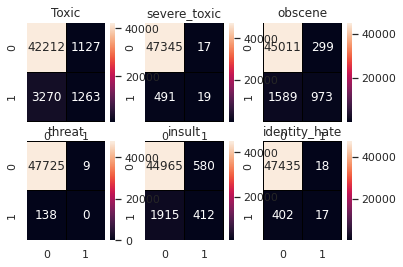

In [ ]:
fig, (ax, ax2) = plt.subplots(2, 3)
sns.set(rc={'figure.figsize':(13,8)})
sns.heatmap(list_confusion_matrix[0],ax=ax[0], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('Toxic')
sns.heatmap(list_confusion_matrix[1],ax=ax[1], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('severe_toxic')
sns.heatmap(list_confusion_matrix[2],ax=ax[2], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('obscene')
sns.heatmap(list_confusion_matrix[3],ax=ax2[0], linecolor='black', linewidths=.1 ,annot=True, fmt='d').set_title('threat')
sns.heatmap(list_confusion_matrix[4],ax=ax2[1], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('insult')
sns.heatmap(list_confusion_matrix[5],ax=ax2[2], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('identity_hate')
plt.show()

### Chain Classifier

In [ ]:
start = timer()
# I've increased the max_iter because of ConvergenceWarning
Lregression = LogisticRegression(random_state=64, max_iter = 300)
lregression_clf = classifier_chain(Lregression, x_train_vector, y_train)
end = timer()
print("Processing time: %.2f seconds" % (end-start))

Processing time: 109.20 seconds


In [ ]:
lregression_pred = predictions(lregression_clf, x_test_vector)
model_accuracy(y_test, lregression_pred)
model_hamming_loss(y_test, lregression_pred)

The model accuracy is: 88.65%
The model hamming loss is: 3.46%


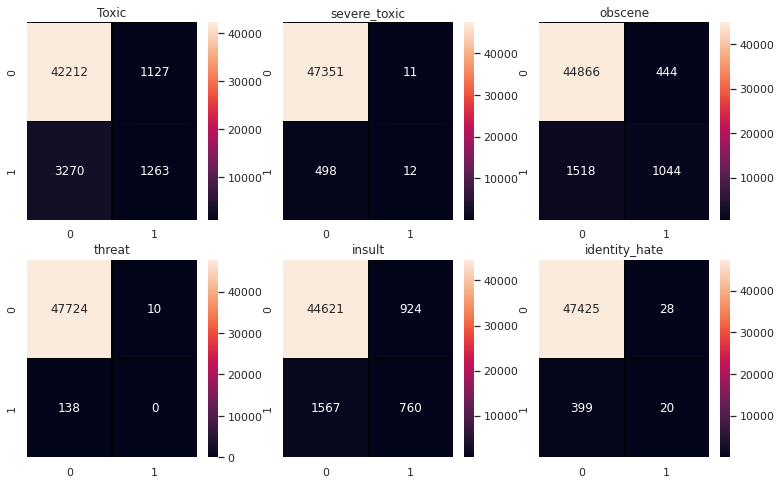

In [ ]:
array_lregression_pred = lregression_pred.toarray()
list_confusion_matrix = []
for idx in range(6):
  conf_matrix = confusion_matrix(y_test.iloc[:,idx], array_lregression_pred[:,idx])
  list_confusion_matrix.append(conf_matrix)

fig, (ax, ax2) = plt.subplots(2, 3)
sns.set(rc={'figure.figsize':(13,8)})
sns.heatmap(list_confusion_matrix[0],ax=ax[0], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('Toxic')
sns.heatmap(list_confusion_matrix[1],ax=ax[1], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('severe_toxic')
sns.heatmap(list_confusion_matrix[2],ax=ax[2], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('obscene')
sns.heatmap(list_confusion_matrix[3],ax=ax2[0], linecolor='black', linewidths=.1 ,annot=True, fmt='d').set_title('threat')
sns.heatmap(list_confusion_matrix[4],ax=ax2[1], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('insult')
sns.heatmap(list_confusion_matrix[5],ax=ax2[2], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('identity_hate')
plt.show()

### Label Powerset

In [ ]:
start = timer()
# I've increased the max_iter because of ConvergenceWarning
# it increased the process time considerably in powerset
Lregression = LogisticRegression(random_state=64, max_iter = 300)
lregression_clf = label_powerset(Lregression, x_train_vector, y_train)
end = timer()
print("Processing time: %.2f seconds" % (end-start))

Processing time: 351.15 seconds


In [ ]:
lregression_pred = predictions(lregression_clf, x_test_vector)
model_accuracy(y_test, lregression_pred)
model_hamming_loss(y_test, lregression_pred)

The model accuracy is: 89.27%
The model hamming loss is: 3.38%


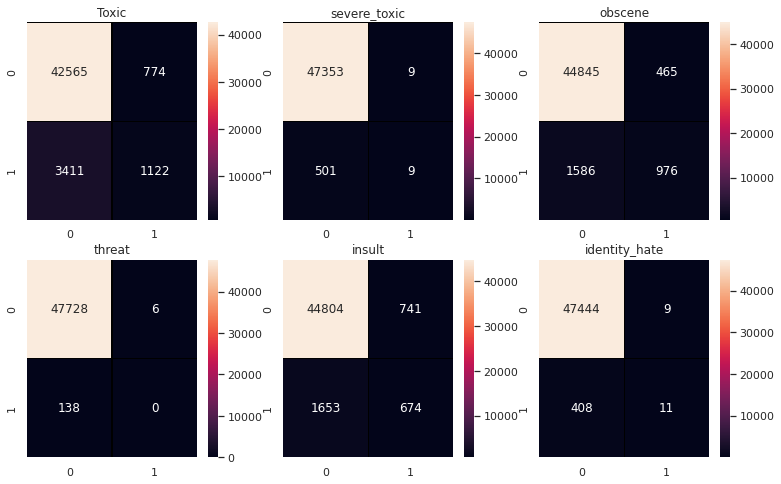

In [ ]:
array_lregression_pred = lregression_pred.toarray()
list_confusion_matrix = []
for idx in range(6):
  conf_matrix = confusion_matrix(y_test.iloc[:,idx], array_lregression_pred[:,idx])
  list_confusion_matrix.append(conf_matrix)

fig, (ax, ax2) = plt.subplots(2, 3)
sns.set(rc={'figure.figsize':(13,8)})
sns.heatmap(list_confusion_matrix[0],ax=ax[0], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('Toxic')
sns.heatmap(list_confusion_matrix[1],ax=ax[1], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('severe_toxic')
sns.heatmap(list_confusion_matrix[2],ax=ax[2], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('obscene')
sns.heatmap(list_confusion_matrix[3],ax=ax2[0], linecolor='black', linewidths=.1 ,annot=True, fmt='d').set_title('threat')
sns.heatmap(list_confusion_matrix[4],ax=ax2[1], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('insult')
sns.heatmap(list_confusion_matrix[5],ax=ax2[2], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('identity_hate')
plt.show()

## Decision Tree

### Binary Relevance

In [ ]:
start = timer()
dtree = DecisionTreeClassifier(random_state=64, max_depth=50)
dtree_clf = binary_relevance(dtree, x_train_vector, y_train)
end = timer()
print("Processing time: %.2f seconds" % (end-start))

Processing time: 622.62 seconds


In [ ]:
dtree_pred = predictions(dtree_clf, x_test_vector)
model_accuracy(y_test, dtree_pred)
model_hamming_loss(y_test, dtree_pred)

The model accuracy is: 82.89%
The model hamming loss is: 4.95%


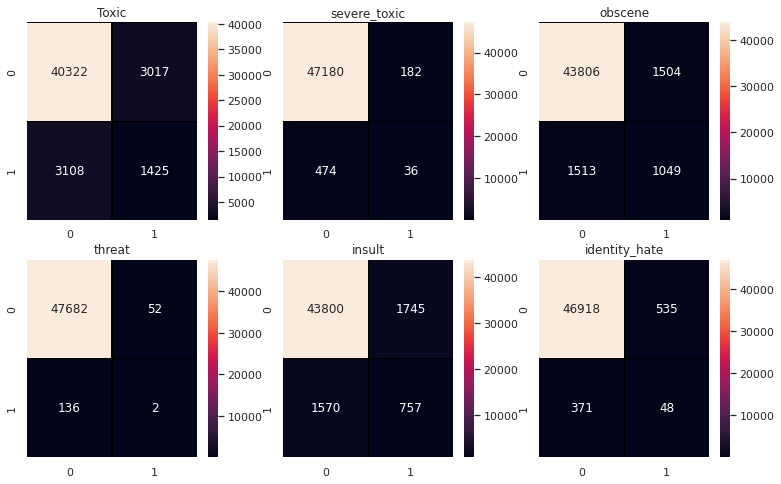

In [ ]:
array_dtree_pred = dtree_pred.toarray()
list_confusion_matrix = []
for idx in range(6):
  conf_matrix = confusion_matrix(y_test.iloc[:,idx], array_dtree_pred[:,idx])
  list_confusion_matrix.append(conf_matrix)

fig, (ax, ax2) = plt.subplots(2, 3)
sns.set(rc={'figure.figsize':(13,8)})
sns.heatmap(list_confusion_matrix[0],ax=ax[0], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('Toxic')
sns.heatmap(list_confusion_matrix[1],ax=ax[1], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('severe_toxic')
sns.heatmap(list_confusion_matrix[2],ax=ax[2], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('obscene')
sns.heatmap(list_confusion_matrix[3],ax=ax2[0], linecolor='black', linewidths=.1 ,annot=True, fmt='d').set_title('threat')
sns.heatmap(list_confusion_matrix[4],ax=ax2[1], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('insult')
sns.heatmap(list_confusion_matrix[5],ax=ax2[2], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('identity_hate')
plt.show()

### Chain Classifier

In [ ]:
start = timer()
dtree = DecisionTreeClassifier(random_state=64, max_depth=50)
dtree_clf = classifier_chain(dtree, x_train_vector, y_train)
end = timer()
print("Processing time: %.2f seconds" % (end-start))

Processing time: 176.21 seconds


In [ ]:
dtree_pred = predictions(dtree_clf, x_test_vector)
model_accuracy(y_test, dtree_pred)
model_hamming_loss(y_test, dtree_pred)

The model accuracy is: 84.29%
The model hamming loss is: 4.77%


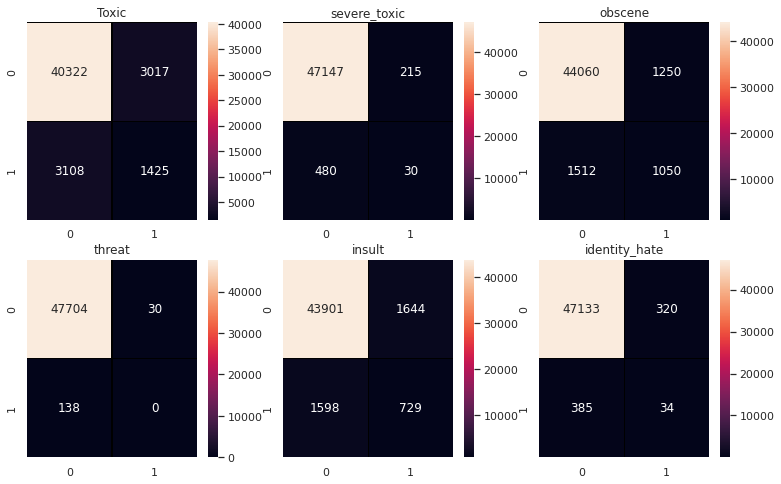

In [ ]:
array_dtree_pred = dtree_pred.toarray()
list_confusion_matrix = []
for idx in range(6):
  conf_matrix = confusion_matrix(y_test.iloc[:,idx], array_dtree_pred[:,idx])
  list_confusion_matrix.append(conf_matrix)

fig, (ax, ax2) = plt.subplots(2, 3)
sns.set(rc={'figure.figsize':(13,8)})
sns.heatmap(list_confusion_matrix[0],ax=ax[0], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('Toxic')
sns.heatmap(list_confusion_matrix[1],ax=ax[1], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('severe_toxic')
sns.heatmap(list_confusion_matrix[2],ax=ax[2], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('obscene')
sns.heatmap(list_confusion_matrix[3],ax=ax2[0], linecolor='black', linewidths=.1 ,annot=True, fmt='d').set_title('threat')
sns.heatmap(list_confusion_matrix[4],ax=ax2[1], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('insult')
sns.heatmap(list_confusion_matrix[5],ax=ax2[2], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('identity_hate')
plt.show()

### Label Power Set

In [ ]:
start = timer()
dtree = DecisionTreeClassifier(random_state=64, max_depth=50)
dtree_clf = label_powerset(dtree, x_train_vector, y_train)
end = timer()
print("Processing time: %.2f seconds" % (end-start))

Processing time: 146.04 seconds


In [ ]:
dtree_pred = predictions(dtree_clf, x_test_vector)
model_accuracy(y_test, dtree_pred)
model_hamming_loss(y_test, dtree_pred)

The model accuracy is: 85.12%
The model hamming loss is: 4.70%


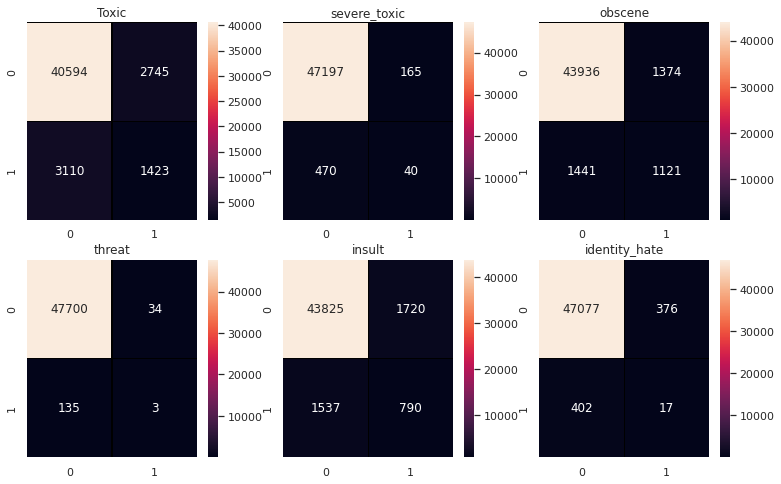

In [ ]:
array_dtree_pred = dtree_pred.toarray()
list_confusion_matrix = []
for idx in range(6):
  conf_matrix = confusion_matrix(y_test.iloc[:,idx], array_dtree_pred[:,idx])
  list_confusion_matrix.append(conf_matrix)

fig, (ax, ax2) = plt.subplots(2, 3)
sns.set(rc={'figure.figsize':(13,8)})
sns.heatmap(list_confusion_matrix[0],ax=ax[0], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('Toxic')
sns.heatmap(list_confusion_matrix[1],ax=ax[1], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('severe_toxic')
sns.heatmap(list_confusion_matrix[2],ax=ax[2], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('obscene')
sns.heatmap(list_confusion_matrix[3],ax=ax2[0], linecolor='black', linewidths=.1 ,annot=True, fmt='d').set_title('threat')
sns.heatmap(list_confusion_matrix[4],ax=ax2[1], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('insult')
sns.heatmap(list_confusion_matrix[5],ax=ax2[2], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('identity_hate')
plt.show()

## MultinomialNB

### Binary Relevance

In [ ]:
start = timer()
mnb = MultinomialNB()
mnb_clf = binary_relevance(mnb, x_train_vector, y_train)
end = timer()
print("Processing time: %.2f seconds" % (end-start))

Processing time: 5.76 seconds


In [ ]:
mnb_pred = predictions(mnb_clf, x_test_vector)
model_accuracy(y_test, mnb_pred)
model_hamming_loss(y_test, mnb_pred)

The model accuracy is: 89.46%
The model hamming loss is: 3.33%


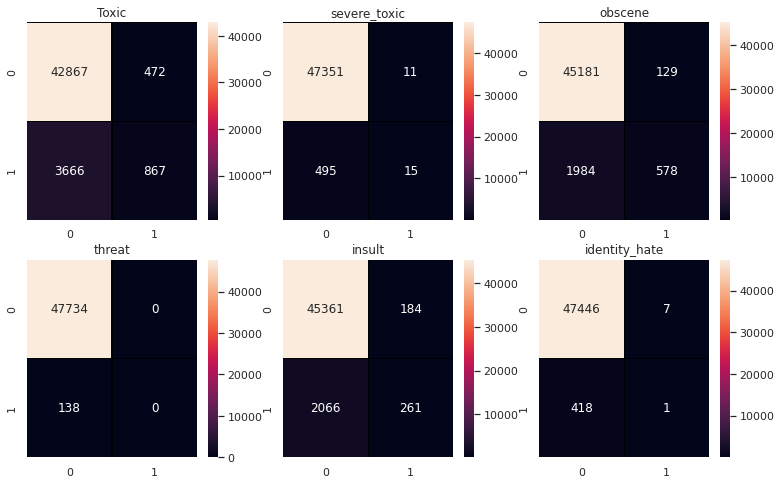

In [ ]:
array_mnb_pred = mnb_pred.toarray()
list_confusion_matrix = []
for idx in range(6):
  conf_matrix = confusion_matrix(y_test.iloc[:,idx], array_mnb_pred[:,idx])
  list_confusion_matrix.append(conf_matrix)

fig, (ax, ax2) = plt.subplots(2, 3)
sns.set(rc={'figure.figsize':(13,8)})
sns.heatmap(list_confusion_matrix[0],ax=ax[0], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('Toxic')
sns.heatmap(list_confusion_matrix[1],ax=ax[1], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('severe_toxic')
sns.heatmap(list_confusion_matrix[2],ax=ax[2], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('obscene')
sns.heatmap(list_confusion_matrix[3],ax=ax2[0], linecolor='black', linewidths=.1 ,annot=True, fmt='d').set_title('threat')
sns.heatmap(list_confusion_matrix[4],ax=ax2[1], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('insult')
sns.heatmap(list_confusion_matrix[5],ax=ax2[2], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('identity_hate')
plt.show()

### Classifier Chain

In [ ]:
start = timer()
mnb = MultinomialNB()
mnb_clf = classifier_chain(mnb, x_train_vector, y_train)
end = timer()
print("Processing time: %.2f seconds" % (end-start))

Processing time: 5.48 seconds


In [ ]:
mnb_pred = predictions(mnb_clf, x_test_vector)
model_accuracy(y_test, mnb_pred)
model_hamming_loss(y_test, mnb_pred)

The model accuracy is: 89.13%
The model hamming loss is: 3.86%


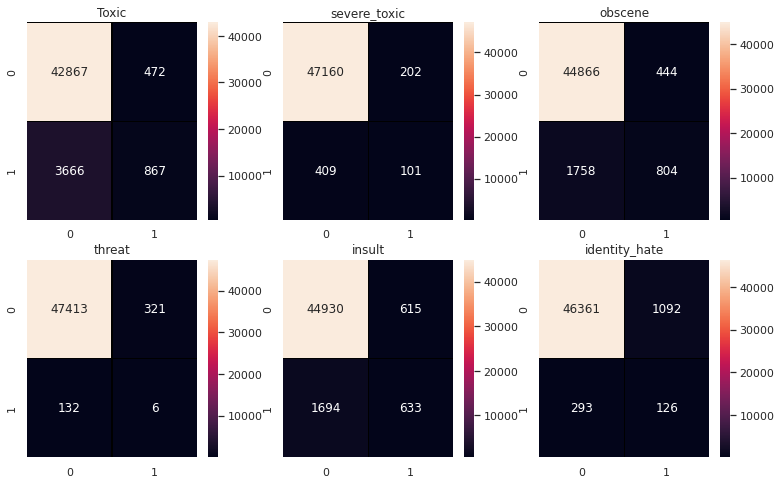

In [ ]:
array_mnb_pred = mnb_pred.toarray()
list_confusion_matrix = []
for idx in range(6):
  conf_matrix = confusion_matrix(y_test.iloc[:,idx], array_mnb_pred[:,idx])
  list_confusion_matrix.append(conf_matrix)

fig, (ax, ax2) = plt.subplots(2, 3)
sns.set(rc={'figure.figsize':(13,8)})
sns.heatmap(list_confusion_matrix[0],ax=ax[0], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('Toxic')
sns.heatmap(list_confusion_matrix[1],ax=ax[1], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('severe_toxic')
sns.heatmap(list_confusion_matrix[2],ax=ax[2], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('obscene')
sns.heatmap(list_confusion_matrix[3],ax=ax2[0], linecolor='black', linewidths=.1 ,annot=True, fmt='d').set_title('threat')
sns.heatmap(list_confusion_matrix[4],ax=ax2[1], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('insult')
sns.heatmap(list_confusion_matrix[5],ax=ax2[2], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('identity_hate')
plt.show()

### Label PowerSet

In [ ]:
start = timer()
mnb = MultinomialNB()
mnb_clf = label_powerset(mnb, x_train_vector, y_train)
end = timer()
print("Processing time: %.2f seconds" % (end-start))

Processing time: 3.06 seconds


In [ ]:
mnb_pred = predictions(mnb_clf, x_test_vector)
model_accuracy(y_test, mnb_pred)
model_hamming_loss(y_test, mnb_pred)

The model accuracy is: 90.08%
The model hamming loss is: 3.33%


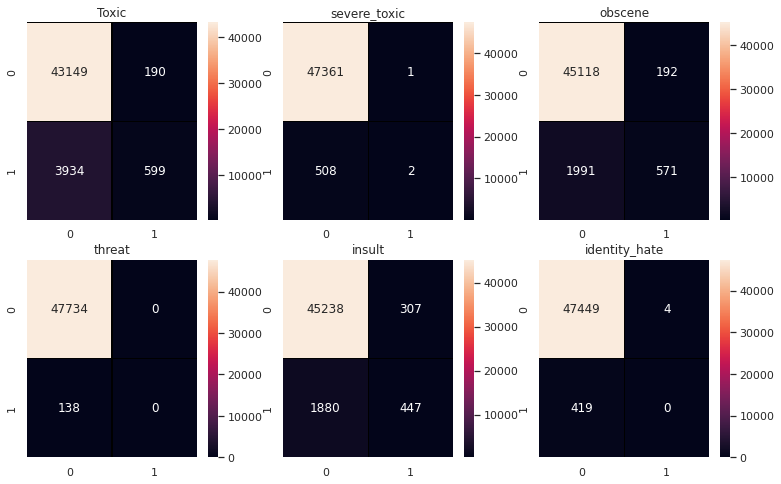

In [ ]:
array_mnb_pred = mnb_pred.toarray()
list_confusion_matrix = []
for idx in range(6):
  conf_matrix = confusion_matrix(y_test.iloc[:,idx], array_mnb_pred[:,idx])
  list_confusion_matrix.append(conf_matrix)

fig, (ax, ax2) = plt.subplots(2, 3)
sns.set(rc={'figure.figsize':(13,8)})
sns.heatmap(list_confusion_matrix[0],ax=ax[0], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('Toxic')
sns.heatmap(list_confusion_matrix[1],ax=ax[1], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('severe_toxic')
sns.heatmap(list_confusion_matrix[2],ax=ax[2], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('obscene')
sns.heatmap(list_confusion_matrix[3],ax=ax2[0], linecolor='black', linewidths=.1 ,annot=True, fmt='d').set_title('threat')
sns.heatmap(list_confusion_matrix[4],ax=ax2[1], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('insult')
sns.heatmap(list_confusion_matrix[5],ax=ax2[2], linecolor='black', linewidths=.1, annot=True, fmt='d').set_title('identity_hate')
plt.show()

## Gaussian NB

### Label Powerset

In [ ]:
start = timer()
gnb = GaussianNB()
gnb_clf = label_powerset(gnb, x_train_vector, y_train)
end = timer()
print("Processing time: %.2f seconds" % (end-start))

Processing time: 4.35 seconds


In [ ]:
gnb_pred = predictions(gnb_clf, x_test_vector)
model_accuracy(y_test, gnb_pred)
model_hamming_loss(y_test, gnb_pred)

The model accuracy is: 38.97%
The model hamming loss is: 20.50%


### Binary Relevance

In [ ]:
start = timer()
gnb = GaussianNB()
gnb_clf = binary_relevance(gnb, x_train_vector, y_train)
end = timer()
print("Processing time: %.2f seconds" % (end-start))

Processing time: 12.48 seconds


In [ ]:
gnb_pred = predictions(gnb_clf, x_test_vector)
model_accuracy(y_test, gnb_pred)
model_hamming_loss(y_test, gnb_pred)

The model accuracy is: 64.79%
The model hamming loss is: 15.94%


### Classifier Chain

In [ ]:
start = timer()
gnb = GaussianNB()
gnb_clf = classifier_chain(gnb, x_train_vector, y_train)
end = timer()
print("Processing time: %.2f seconds" % (end-start))

Processing time: 14.62 seconds


In [ ]:
gnb_pred = predictions(gnb_clf, x_test_vector)
model_accuracy(y_test, gnb_pred)
model_hamming_loss(y_test, gnb_pred)

The model accuracy is: 67.10%
The model hamming loss is: 15.55%
